In [1]:
import os
os.chdir("..")
from data.data_classes import *
from data.datamodules import Graph_DataModule
import matplotlib.pyplot as plt
import numpy as np
from data.data_classes import MyCIFAR_10, MyOmniglot
from math import log10, sqrt
from enums import Partition

In [2]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [3]:
def plot(idx: int, dataset: SourceDataset, mode: Partition, num_segments: int):
    # Create datamodule
    name = dataset.name
    data_module = Graph_DataModule(dataset, num_segments, 1, mode, {"x_center":True, "y_center":True, "colour":True, "num_pixels":True})

    # Get all forms of the data to be shown
    original_img = np.asarray(data_module.test_set[idx][0])
    segmented_img = data_module.partition_test_set[idx][0]
    graph_data =  data_module.graph_test_set[idx]
    node_data = graph_data.x.detach().numpy().copy()
    label = dataset.idx_to_class(data_module.test_set[idx][1])

    # Unnormalise the graph data (x, y, size)
    node_data[:, 0] *= dataset.shape[1]
    node_data[:, 1] *= dataset.shape[0]
    node_data[:, data_module.num_features - 1] *= (np.prod(dataset.shape[:2]))

    # Obtain the edges of the graph data
    values, _ = graph_data.edge_index.t().sort()
    edges = values.unique(dim=0)

    # Create plotting space and plot parameters
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(22, 5))
    fontsize = 13.5

    # Plot original image
    ax1.imshow(original_img, cmap="gray")
    ax1.set_title(f"{name.upper()} Original Image {idx} | Label = {label.upper()}", fontsize = fontsize)
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Plot partitioned image
    ax2.imshow(segmented_img, cmap="gray")
    if mode is Partition.CuPID:
        ax2.set_title(f"Image Segmented by CuPID-{num_segments}", fontsize = fontsize)
    elif mode is Partition.SLIC:
        ax2.set_title(f"Image Segmented by SLIC-{num_segments}", fontsize = fontsize)
    ax2.set_xticks([])
    ax2.set_yticks([])

    # Setup the plot for the graph representation of the image
    ax3.invert_yaxis()
    if name.lower() != "omniglot":
        ax3.set_facecolor("black")
    if mode is Partition.CuPID:
        ax3.set_title(f"CuPID Image as Graph ({len(node_data)} nodes)", fontsize = fontsize)
    elif mode is Partition.SLIC:
        ax3.set_title(f"SLIC Image as Graph ({len(node_data)} nodes)", fontsize = fontsize)
    ax3.set_xticks([])
    ax3.set_yticks([])

    # Setup the plot for the graph representation of the image with scaled nodes
    ax4.invert_yaxis()
    if name.lower() != "omniglot":
        ax4.set_facecolor("black")
    if mode is Partition.CuPID:
        ax4.set_title("CuPID Image as Scaled Graph", fontsize = fontsize)
    elif mode is Partition.SLIC:
        ax4.set_title("SLIC Image as Scaled Graph", fontsize = fontsize)
    ax4.set_xticks([])
    ax4.set_yticks([])

    # Add nodes to the graph plots
    for i in range(len(node_data)):
        if data_module.num_features > 4:
            ax3.add_patch(plt.Circle((node_data[i][0], node_data[i][1]), 0.25, facecolor=node_data[i][2:5], edgecolor="white", linewidth=0.2))
            ax4.add_patch(plt.Circle((node_data[i][0], node_data[i][1]), 0.35*np.sqrt(node_data[i][5]), facecolor=node_data[i][2:5], edgecolor="white", linewidth=0.5))
        else:
            if name.lower() != "omniglot":
                ax3.add_patch(plt.Circle((node_data[i][0], node_data[i][1]), 0.25, facecolor=str(node_data[i][2].item()), edgecolor="white", linewidth=0.2))
                ax4.add_patch(plt.Circle((node_data[i][0], node_data[i][1]), 0.35*np.sqrt(node_data[i][3]), facecolor=str(node_data[i][2].item()), edgecolor="white", linewidth=0.5))
            else:
                ax3.add_patch(plt.Circle((node_data[i][0], node_data[i][1]), 0.25, facecolor=str(node_data[i][2].item()), edgecolor="black", linewidth=0.2))
                ax4.add_patch(plt.Circle((node_data[i][0], node_data[i][1]), 0.35*np.sqrt(node_data[i][3]), facecolor=str(node_data[i][2].item()), edgecolor="black", linewidth=0.5))

    # Add edges to the graph plots
    for i in range(len(edges)):
        # Get source cuboid information
        src_cuboid = node_data[edges[i][0]]
        x_src = src_cuboid[0]
        y_src = src_cuboid[1]

        # Get destination cuboid information
        dst_cuboid = node_data[edges[i][1]]
        x_dst = dst_cuboid[0]
        y_dst = dst_cuboid[1]

        if name.lower() != "omniglot":
            ax3.plot([x_src, x_dst], [y_src, y_dst], color="w", linestyle='-', linewidth=0.5)
            ax4.plot([x_src, x_dst], [y_src, y_dst], color="w", linestyle='-', linewidth=0.5)
        else:
            ax3.plot([x_src, x_dst], [y_src, y_dst], color="k", linestyle='-', linewidth=0.5)
            ax4.plot([x_src, x_dst], [y_src, y_dst], color="k", linestyle='-', linewidth=0.5)

    # Plot the subplots
    ax3.set_box_aspect(1)
    ax4.set_box_aspect(1)
    plt.show()

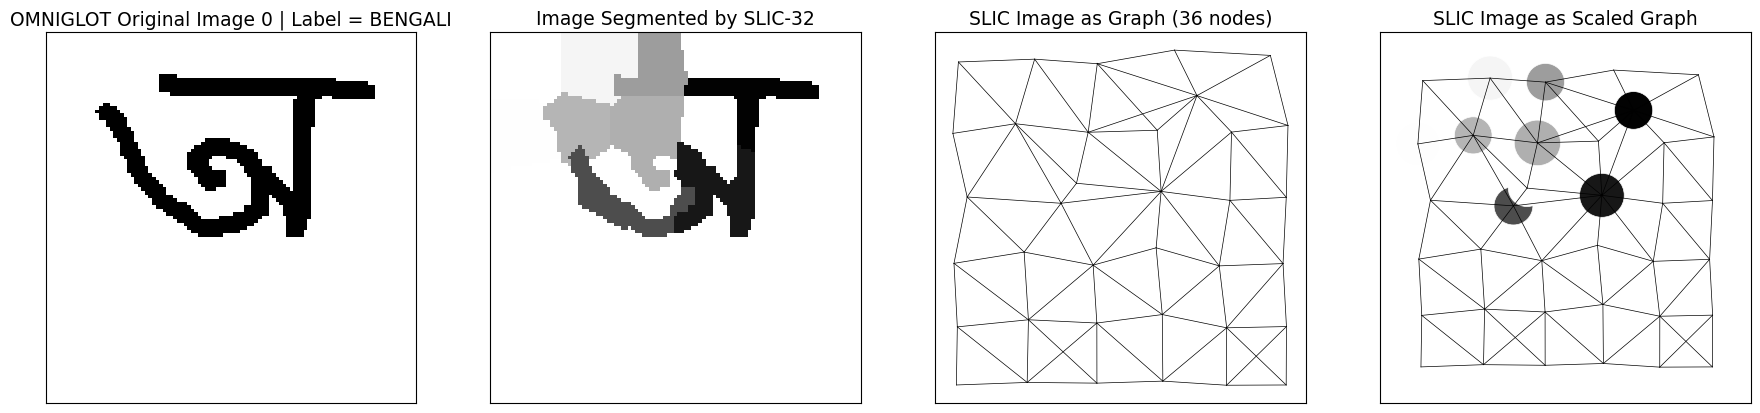

In [18]:
idx = 0
plot(idx, MyOmniglot(), Partition.SLIC, 32)

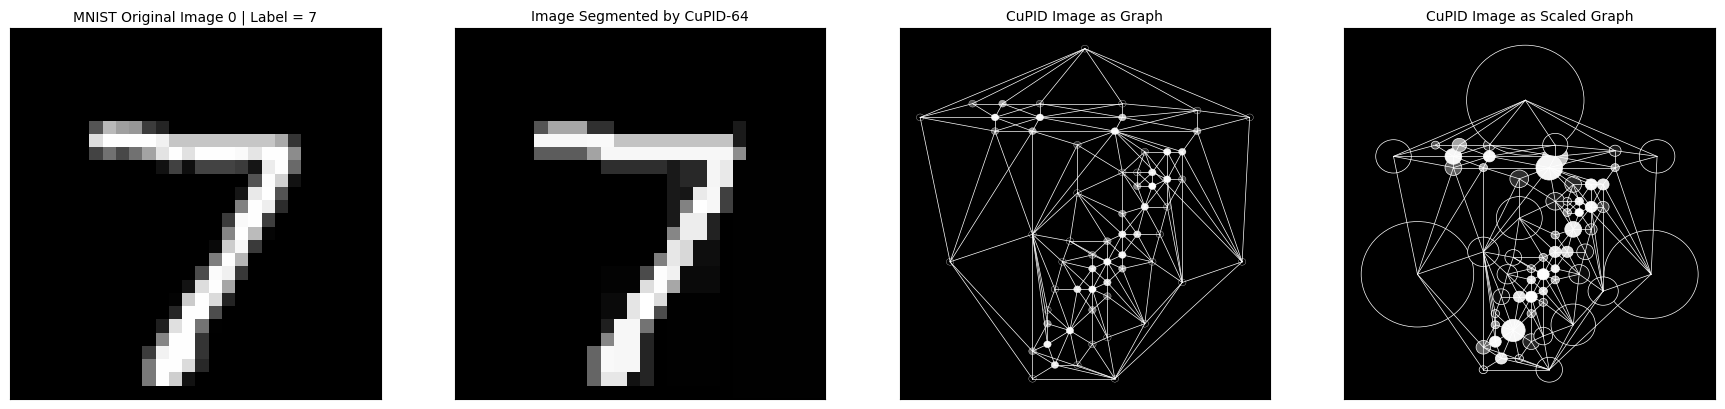